# Using the Data Imputator on a Real Public Dataset, Herold et al. (2020)

In this example, we will be using the GP imputator on a dataset available at [Herold et al., 2020](https://doi.org/10.1038/s41467-020-19006-2).

In [1]:
import matplotlib.pyplot as plt
import numpy as np


import pandas as pd
import seaborn as sns


from mimic.data_imputation.impute_GP import GPImputer
from mimic.model_infer.infer_VAR import *

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [ ]:
data = pd.read_csv(r'Source Data/fig3ab.tsv', delimiter='\t')

data.head(15)

genus        date       val type
0   Acidimicrobium  2011-03-21  8.322484   MG
1   Acidimicrobium  2011-03-29  7.664534   MG
2   Acidimicrobium  2011-04-05  7.871188   MG
3   Acidimicrobium  2011-04-14  6.695900   MG
4   Acidimicrobium  2011-04-21  6.695177   MG
5   Acidimicrobium  2011-04-29  6.304652   MG
6   Acidimicrobium  2011-05-06  7.462918   MG
7   Acidimicrobium  2011-05-13  7.742366   MG
8   Acidimicrobium  2011-05-20  6.627358   MG
9   Acidimicrobium  2011-05-27  7.425880   MG
10  Acidimicrobium  2011-06-03  7.890684   MG
11  Acidimicrobium  2011-06-09  6.306718   MG
12  Acidimicrobium  2011-06-17  6.607237   MG
13  Acidimicrobium  2011-06-24  8.888402   MG
14  Acidimicrobium  2011-07-01  9.086751   MG

# Separate the data into MG and MT datasets

The data is separated into two datasets, MG and MT. The MG dataset contains the meta-genomics data, while the MT dataset contains the meta-transcriptomics. We will be using the MG dataset in this example.


In [ ]:
# separate the data into MG and MT datasets

dataMG = data[data['type'] == 'MG']

dataMG.info()

dataMT = data[data['type'] == 'MT']

dataMT.info()

<class 'pandas.core.frame.DataFrame'>
Index: 612 entries, 0 to 611
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   genus   561 non-null    object 
 1   date    612 non-null    object 
 2   val     612 non-null    float64
 3   type    612 non-null    object 
dtypes: float64(1), object(3)
memory usage: 23.9+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 561 entries, 612 to 1172
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   genus   510 non-null    object 
 1   date    561 non-null    object 
 2   val     561 non-null    float64
 3   type    561 non-null    object 
dtypes: float64(1), object(3)
memory usage: 21.9+ KB


In [ ]:
# Data cleaning
# Rename Nan in the genus column to 'Other'

dataMG['genus'] = dataMG['genus'].replace(np.nan, 'Other')

# Drop the 'type' column
dataMG = dataMG.drop(columns=['type'])

# Change relative Date columns to days
dataMG['date'] = pd.to_datetime(dataMG['date'])
dataMG['date'] = (dataMG['date'] - dataMG['date'].min()).dt.days

# Change the 'genus' column to a categorical column
dataMG['genus'] = dataMG['genus'].astype('category')


dataMG.info()

<class 'pandas.core.frame.DataFrame'>
Index: 612 entries, 0 to 611
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   genus   612 non-null    category
 1   date    612 non-null    int64   
 2   val     612 non-null    float64 
dtypes: category(1), float64(1), int64(1)
memory usage: 15.3 KB


C:\Users\User\AppData\Local\Temp\ipykernel_16348\1446871442.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataMG['genus'] = dataMG['genus'].replace(np.nan, 'Other')


c:\ProgramData\anaconda3\envs\MIMIC\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\envs\MIMIC\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\envs\MIMIC\Lib\site-packages\seaborn\_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(


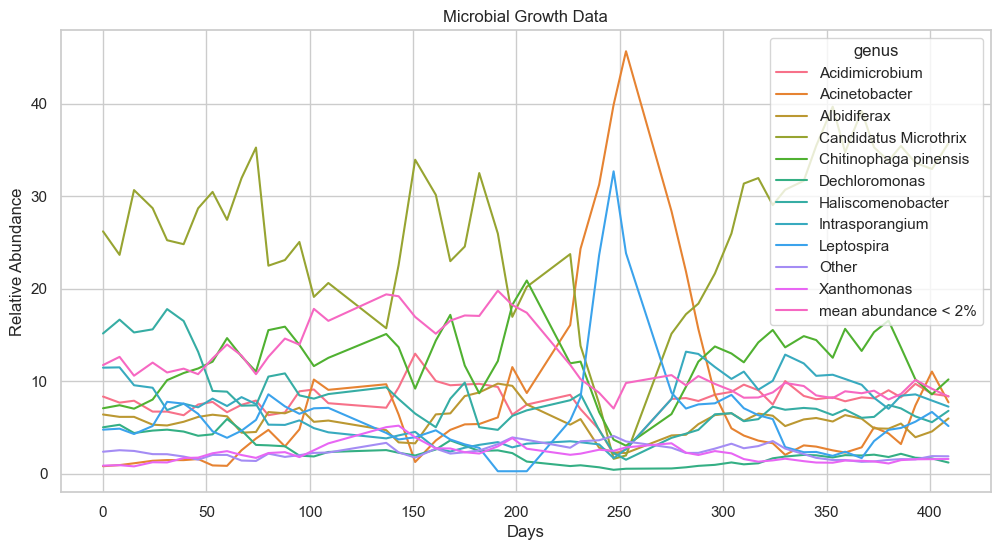

In [ ]:
# Plot the data, relative abundance (value) vs. days (date) for each genus


sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='val', hue='genus', data=dataMG)
plt.title('Microbial Growth Data')
plt.xlabel('Days')
plt.ylabel('Relative Abundance')
plt.show()

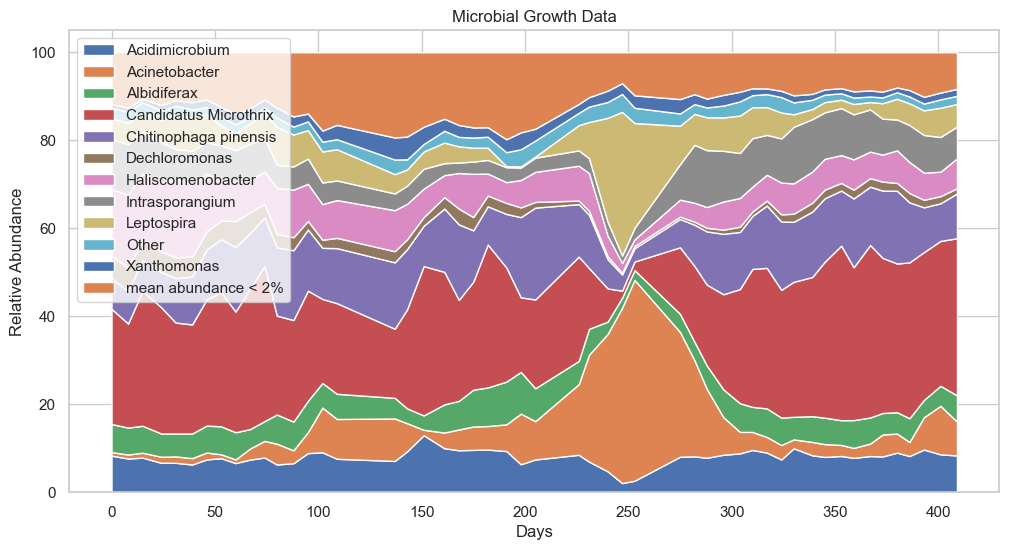

In [ ]:
# Pivot the data so each 'genus' is a column
dataMG_pivot = dataMG.pivot(
    index='date', columns='genus', values='val').fillna(0)

# Create a stacked area chart
plt.figure(figsize=(12, 6))
plt.stackplot(dataMG_pivot.index, dataMG_pivot.T, labels=dataMG_pivot.columns)

plt.title('Microbial Growth Data')
plt.xlabel('Days')
plt.ylabel('Relative Abundance')
plt.legend(loc='upper left')

plt.show()

In [ ]:

# Create a DataFrame with a complete range of days
all_days = pd.DataFrame(
    {'days': range(dataMG['date'].min(), dataMG['date'].max() + 1)})

# Reindex the pivoted DataFrame to include all days, filling missing values with None
complete_dataMG = dataMG_pivot.reindex(all_days['days'])

complete_dataMG.head(15)

genus  Acidimicrobium  Acinetobacter  Albidiferax  Candidatus Microthrix  \
days                                                                       
0            8.322484       0.791870     6.383491              26.180838   
1                 NaN            NaN          NaN                    NaN   
2                 NaN            NaN          NaN                    NaN   
3                 NaN            NaN          NaN                    NaN   
4                 NaN            NaN          NaN                    NaN   
5                 NaN            NaN          NaN                    NaN   
6                 NaN            NaN          NaN                    NaN   
7                 NaN            NaN          NaN                    NaN   
8            7.664534       0.911291     6.125822              23.641355   
9                 NaN            NaN          NaN                    NaN   
10                NaN            NaN          NaN                    NaN   
11                NaN            NaN          NaN                    NaN   
12                NaN            NaN          NaN                    NaN   
13                NaN            NaN          NaN                    NaN   
14                NaN            NaN          NaN                    NaN   

genus  Chitinophaga pinensis  Dechloromonas  Haliscomenobacter  \
days                                                             
0                   7.055585       4.998287          15.142620   
1                        NaN            NaN                NaN   
2                        NaN            NaN                NaN   
3                        NaN            NaN                NaN   
4                        NaN            NaN                NaN   
5                        NaN            NaN                NaN   
6                        NaN            NaN                NaN   
7                        NaN            NaN                NaN   
8                   7.383681       5.273044          16.636265   
9                        NaN            NaN                NaN   
10                       NaN            NaN                NaN   
11                       NaN            NaN                NaN   
12                       NaN            NaN                NaN   
13                       NaN            NaN                NaN   
14                       NaN            NaN                NaN   

genus  Intrasporangium  Leptospira     Other  Xanthomonas  mean abundance < 2%  
days                                                                            
0            11.445072    4.742982  2.357318     0.853658            11.725795  
1                  NaN         NaN       NaN          NaN                  NaN  
2                  NaN         NaN       NaN          NaN                  NaN  
3                  NaN         NaN       NaN          NaN                  NaN  
4                  NaN         NaN       NaN          NaN                  NaN  
5                  NaN         NaN       NaN          NaN                  NaN  
6                  NaN         NaN       NaN          NaN                  NaN  
7                  NaN         NaN       NaN          NaN                  NaN  
8            11.476739    4.850959  2.520630     0.903478            12.612201  
9                  NaN         NaN       NaN          NaN                  NaN  
10                 NaN         NaN       NaN          NaN                  NaN  
11                 NaN         NaN       NaN          NaN                  NaN  
12                 NaN         NaN       NaN          NaN                  NaN  
13                 NaN         NaN       NaN          NaN                  NaN  
14                 NaN         NaN       NaN          NaN                  NaN

In [ ]:
complete_dataMG.columns

CategoricalIndex(['Acidimicrobium', 'Acinetobacter', 'Albidiferax',
                  'Candidatus Microthrix', 'Chitinophaga pinensis',
                  'Dechloromonas', 'Haliscomenobacter', 'Intrasporangium',
                  'Leptospira', 'Other', 'Xanthomonas', 'mean abundance < 2%'],
                 categories=['Acidimicrobium', 'Acinetobacter', 'Albidiferax', 'Candidatus Microthrix', ..., 'Leptospira', 'Other', 'Xanthomonas', 'mean abundance < 2%'], ordered=False, dtype='category', name='genus')

In [ ]:
complete_dataMG['Acinetobacter'].isnull().sum()

359

In [ ]:
# Reset the index
complete_dataMG_reset = complete_dataMG.reset_index()

# Make index as float
complete_dataMG_reset['days'] = complete_dataMG_reset['days'].astype(float)

Model: VGP
Best kernel: <class 'gpflow.kernels.stationaries.RationalQuadratic'>
BIC: 236147.03324540867


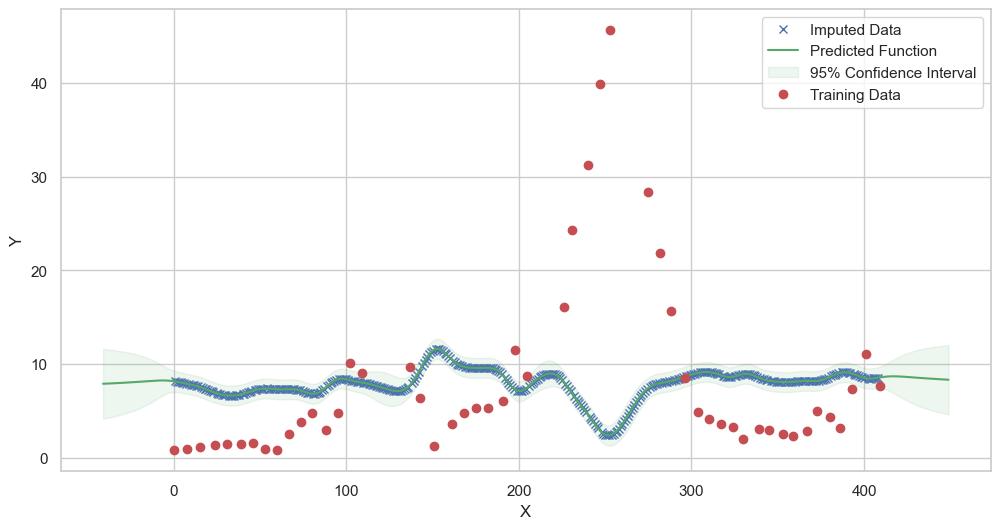

In [ ]:
# Now 'days' is a regular column and you can use it as a feature
new_dataset = GPImputer().impute_missing_values(
    complete_dataMG_reset, ['days'], ['Acidimicrobium',
                                      'Acinetobacter', 'Albidiferax'], 'Acinetobacter'
)

In [ ]:
new_dataset['Acinetobacter'].isnull().sum()

0

Model: VGP
Best kernel: <class 'gpflow.kernels.stationaries.RationalQuadratic'>
BIC: 4811115.618247565


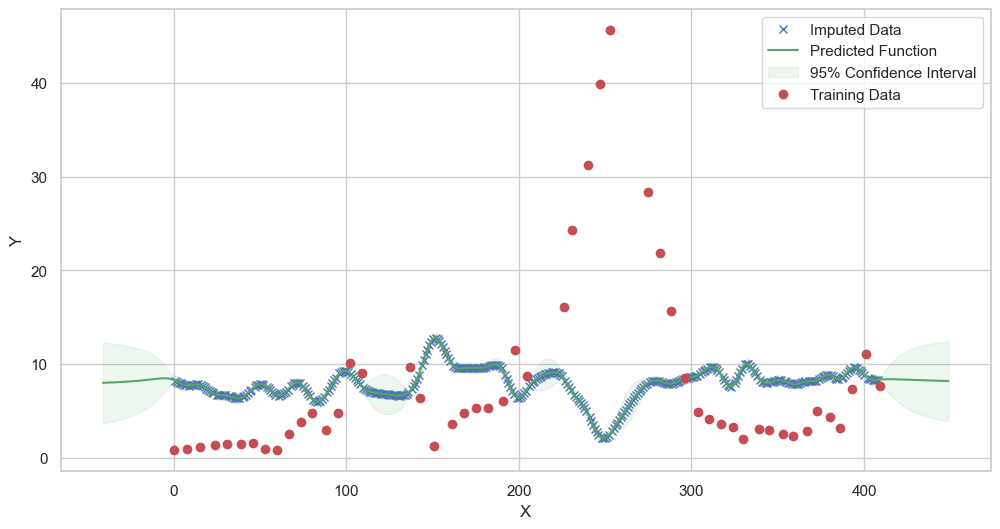

In [ ]:
# Now 'days' is a regular column and you can use it as a feature
new_dataset = GPImputer().impute_missing_values(
    complete_dataMG_reset, ['days'], ['Acidimicrobium', 'Acinetobacter', 'Albidiferax',
                                      'Candidatus Microthrix', 'Chitinophaga pinensis',
                                      'Dechloromonas', 'Haliscomenobacter', 'Intrasporangium',
                                      'Leptospira', 'Other', 'Xanthomonas', 'mean abundance < 2%'], 'Acinetobacter'
)

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.RationalQuadratic'>
BIC: -248.40300696649717


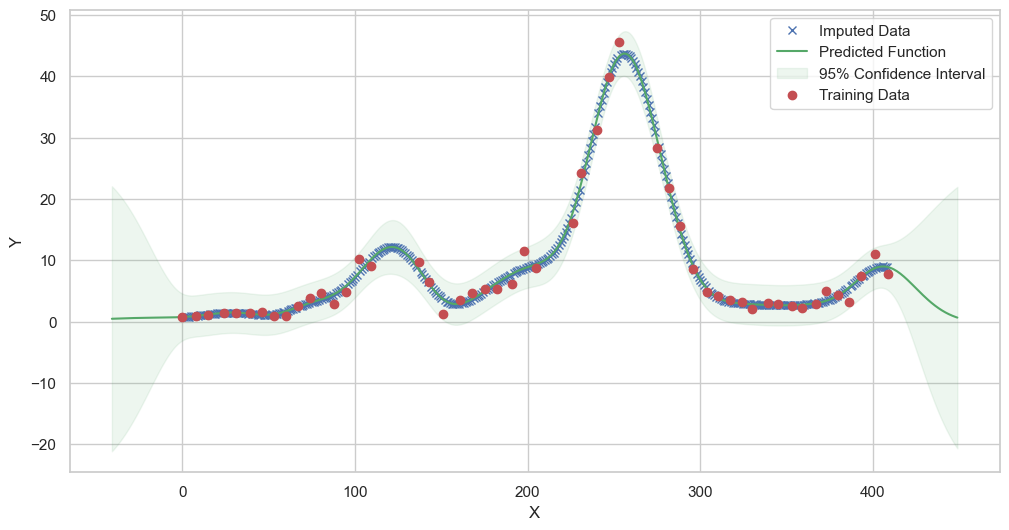

In [ ]:
# Now 'days' is a regular column and you can use it as a feature
new_dataset2 = GPImputer().impute_missing_values(
    complete_dataMG_reset, ['days'], ['Acinetobacter'], 'Acinetobacter'
)

In [ ]:
# Save the dataset (new_dataset2) to a csv file
new_dataset2.to_csv(r'imputed_data.csv', index=False)

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.RationalQuadratic'>
BIC: -162.28151984461607


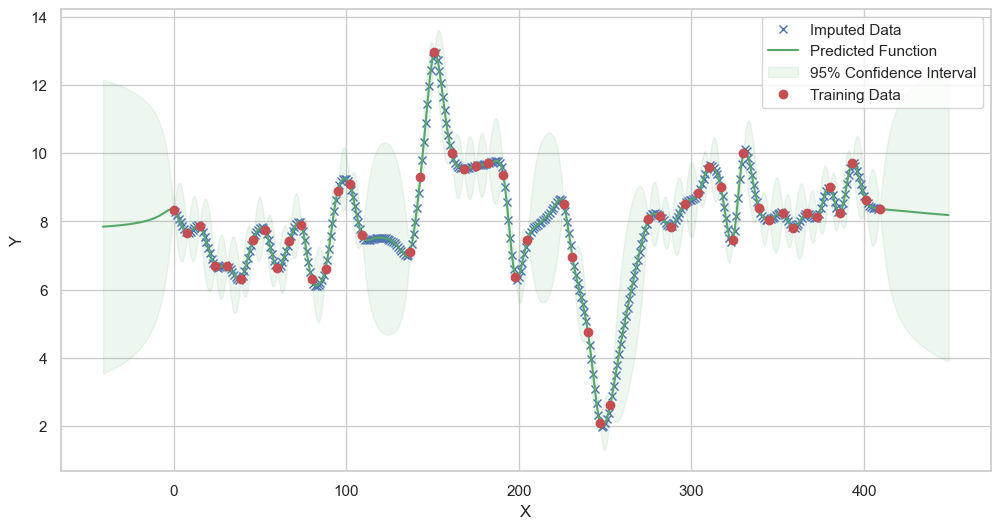

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.RationalQuadratic'>
BIC: -248.40300696649717


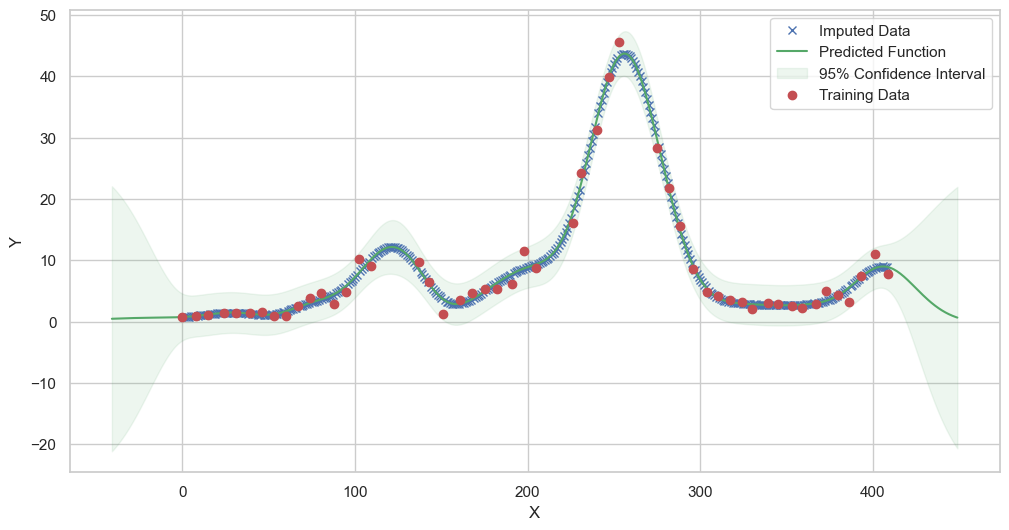

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.RationalQuadratic'>
BIC: -137.06584629672068


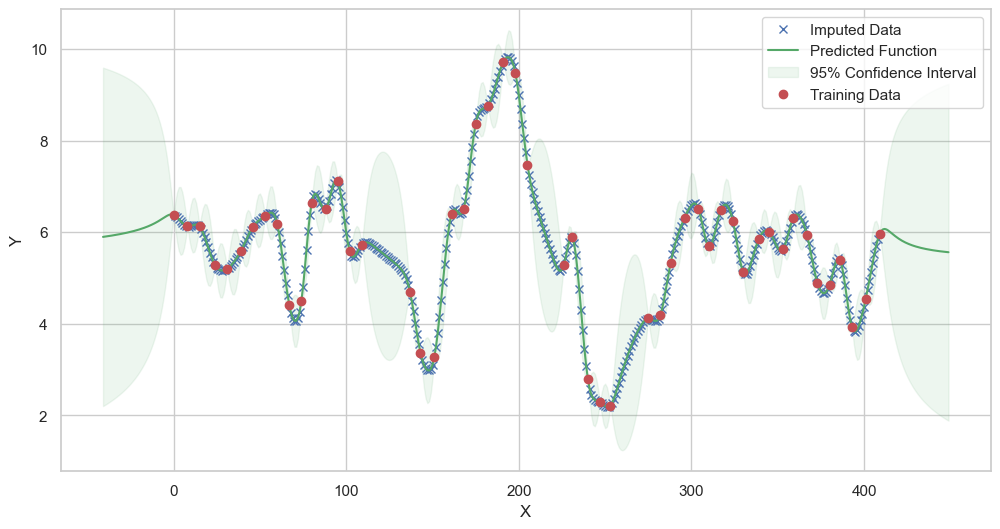

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.RationalQuadratic'>
BIC: -297.92365659240966


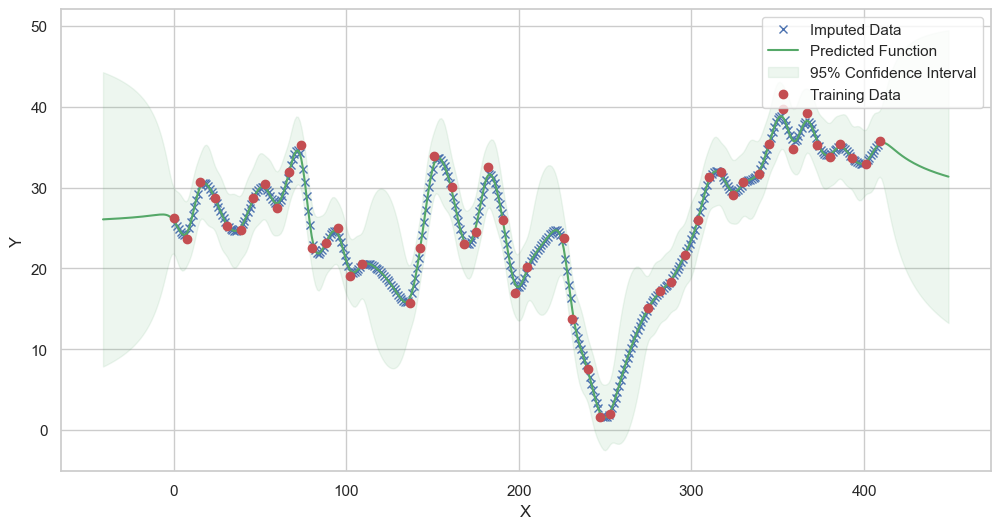

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.RationalQuadratic'>
BIC: -225.68501007391774


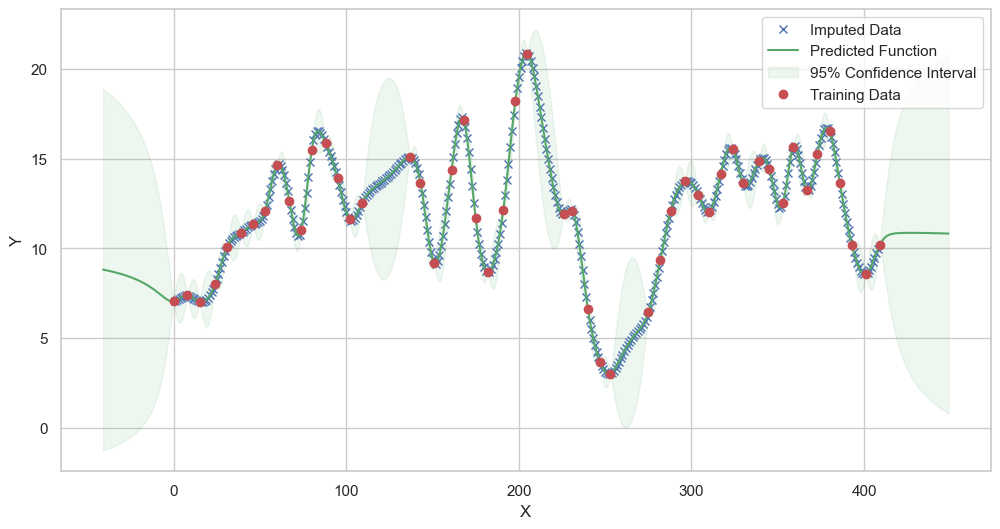

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.RationalQuadratic'>
BIC: -71.0838410931403


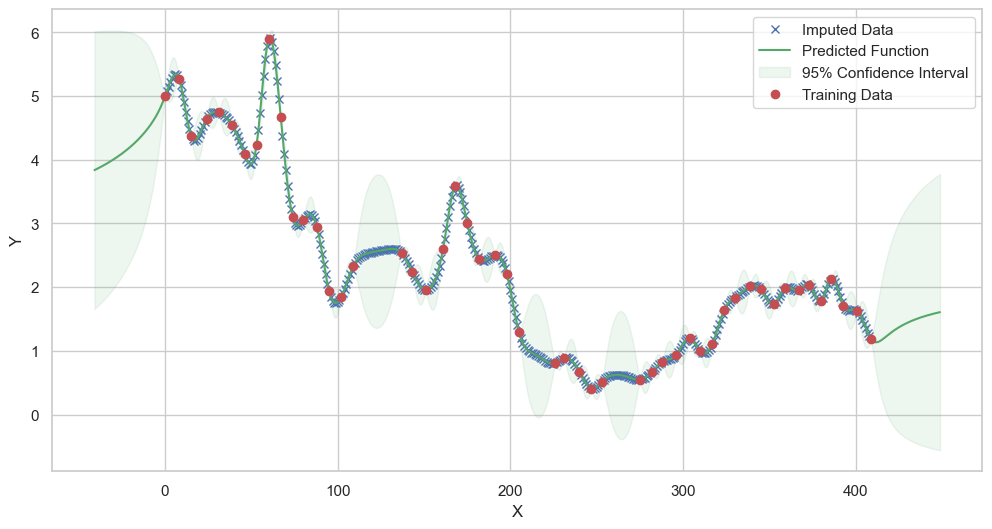

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.RationalQuadratic'>
BIC: -181.18602198312468


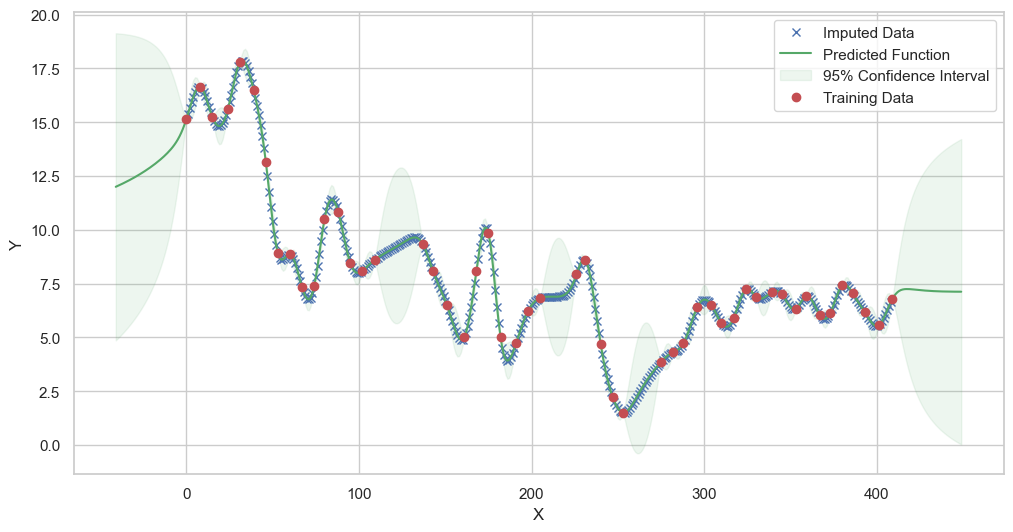

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.RationalQuadratic'>
BIC: -168.5312326022697


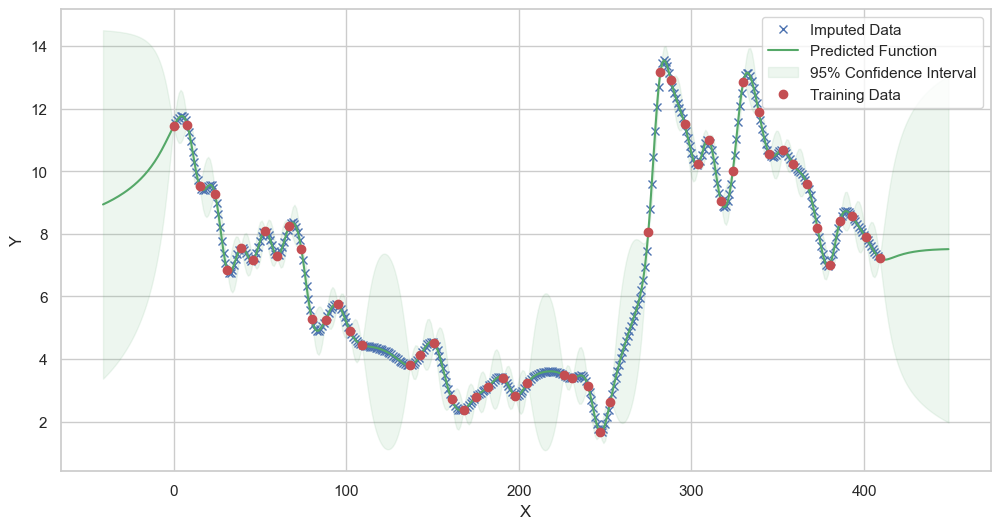

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.RationalQuadratic'>
BIC: -236.7104662129815


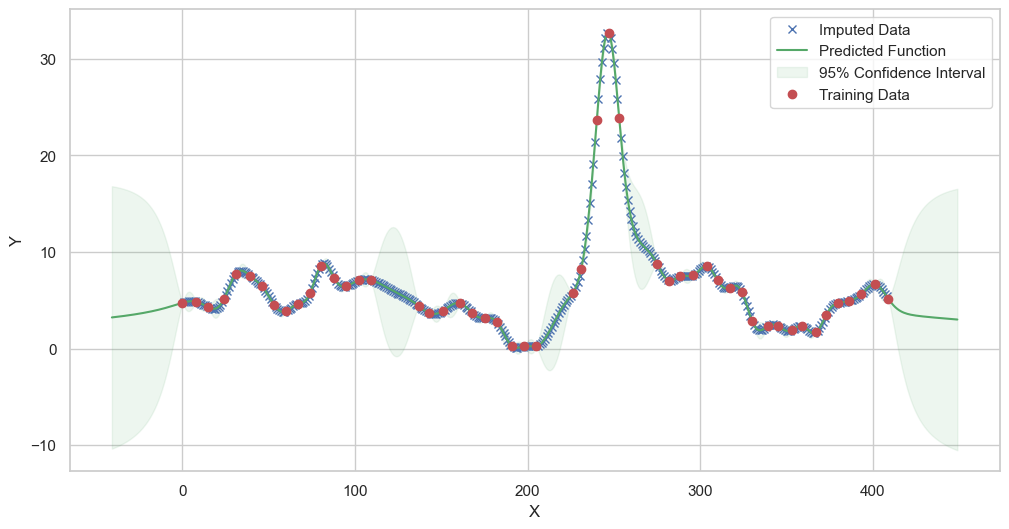

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.RationalQuadratic'>
BIC: -51.797015513175154


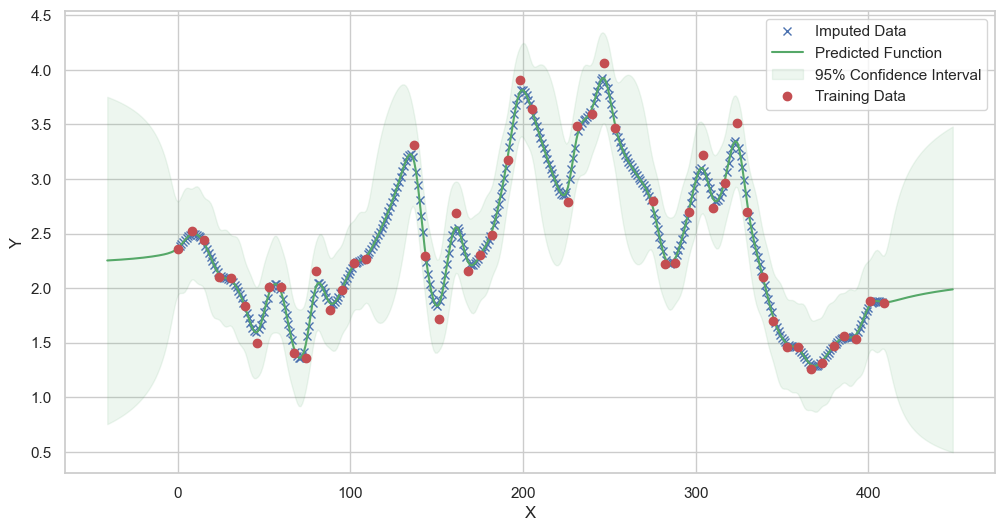

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.RationalQuadratic'>
BIC: -54.937802829878464


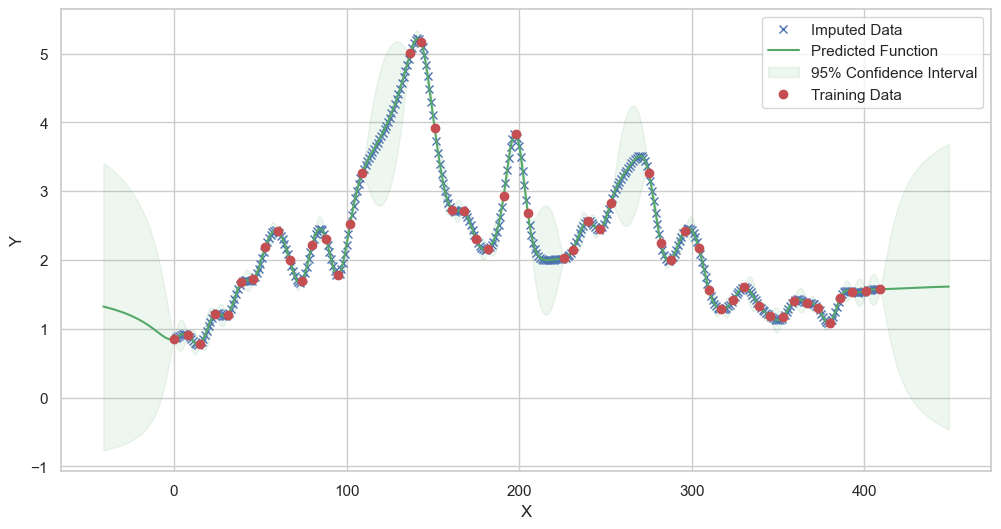

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.Exponential'>
BIC: -178.35294381418785


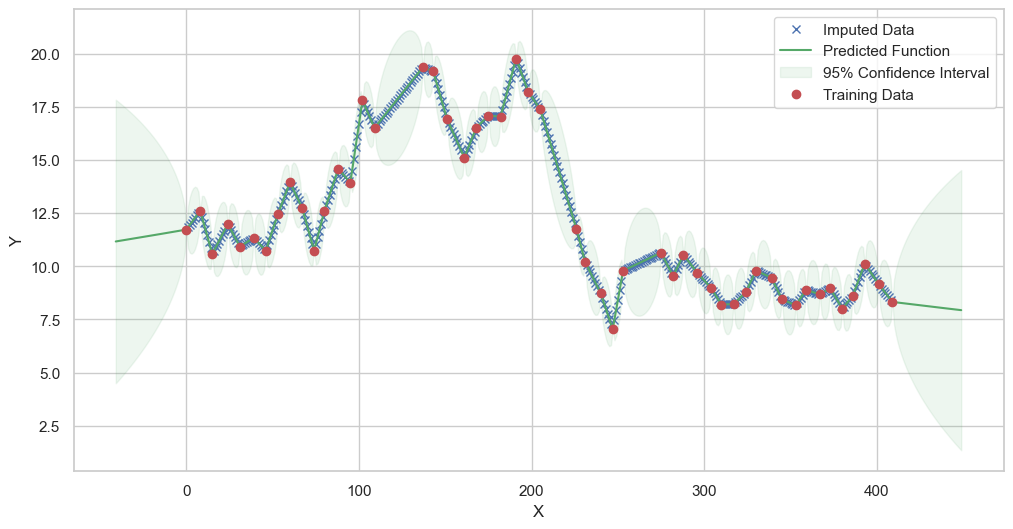

In [ ]:
# do the imputation for each column (genus) in the dataset
# Copy the original dataset
new_dataset_complete = complete_dataMG_reset.copy()

for genus in complete_dataMG.columns:
    # Impute the missing values for the current column
    imputed_data = GPImputer().impute_missing_values(
        complete_dataMG_reset, ['days'], [genus], genus
    )

    # Update the column in the new dataset with the imputed data
    new_dataset_complete[genus] = imputed_data[genus]

# Save the dataset (new_dataset_complete) to a csv file
new_dataset_complete.to_csv('imputed_data.csv', index=False)

In [2]:
# Reload the imputed data into a new DataFrame

imputed_data = pd.read_csv('imputed_data.csv')

imputed_data.head(15)

days  Acidimicrobium  Acinetobacter  Albidiferax  Candidatus Microthrix  \
0    0.0        8.322484       0.791870     6.383491              26.180838   
1    1.0        8.265177       0.763703     6.362575              25.593890   
2    2.0        8.180701       0.781881     6.330330              25.226861   
3    3.0        8.078737       0.801890     6.290243              24.849371   
4    4.0        7.969807       0.823758     6.246734              24.505012   
5    5.0        7.863614       0.847488     6.204391              24.245813   
6    6.0        7.770084       0.873055     6.167656              24.127242   
7    7.0        7.700314       0.900405     6.140528              24.199845   
8    8.0        7.664534       0.911291     6.125822              23.641355   
9    9.0        7.666801       0.960073     6.124129              25.024940   
10  10.0        7.701597       0.992116     6.133189              25.753165   
11  11.0        7.756540       1.025393     6.148177              26.621835   
12  12.0        7.816900       1.059680     6.162504              27.550701   
13  13.0        7.867041       1.094721     6.168573              28.452806   
14  14.0        7.890203       1.130229     6.158709              29.247651   

    Chitinophaga pinensis  Dechloromonas  Haliscomenobacter  Intrasporangium  \
0                7.055585       4.998287          15.142620        11.445072   
1                7.081694       5.072711          15.397948        11.546582   
2                7.127157       5.147886          15.663537        11.636934   
3                7.185821       5.219273          15.926969        11.710476   
4                7.249498       5.280679          16.172482        11.759176   
5                7.309111       5.324508          16.382314        11.772278   
6                7.355842       5.342460          16.538718        11.737040   
7                7.382293       5.326927          16.626579        11.641157   
8                7.383681       5.273044          16.636265        11.476739   
9                7.358852       5.180566          16.565955        11.244474   
10               7.310707       5.055128          16.422573        10.955857   
11               7.245802       4.907436          16.220878        10.632238   
12               7.173270       4.751605          15.981051        10.301403   
13               7.103389       4.602845          15.725567         9.993155   
14               7.046066       4.475146          15.476159         9.734647   

    Leptospira     Other  Xanthomonas  mean abundance < 2%  
0     4.742982  2.357318     0.853658            11.725795  
1     4.791269  2.382206     0.864697            11.836536  
2     4.833619  2.399779     0.879132            11.947293  
3     4.868031  2.418784     0.894873            12.058067  
4     4.892380  2.438263     0.909303            12.168858  
5     4.904550  2.457029     0.919595            12.279667  
6     4.902619  2.473734     0.923138            12.390494  
7     4.885061  2.487002     0.918012            12.501338  
8     4.850959  2.520630     0.903478            12.612201  
9     4.800196  2.499159     0.880339            12.321359  
10    4.733611  2.497398     0.851104            12.030537  
11    4.653122  2.490776     0.819790            11.739731  
12    4.561808  2.479674     0.791448            11.448942  
13    4.463977  2.464200     0.771427            11.158170  
14    4.365213  2.444171     0.764505            10.867413

In [3]:
infer = infer_VAR(imputed_data)
infer.run_inference()

x0: Shape.0
data[1:, :]: (409, 13)
x0: (13, 1)
mu: Shape.0
data: (409, 13)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x0, A, noise_chol]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 5034 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 4000 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\envs\MIMIC\Lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\User\AppData\Local\Temp\ipykernel_29172\1408056054.py", line 2, in <module>
    infer.run_inference()
  File "C:\Users\User\Documents\GitHub\MIMIC\mimic\model_infer\infer_VAR.py", line 145, in run_inference
  File "c:\ProgramData\anaconda3\envs\MIMIC\Lib\site-packages\arviz\stats\stats.py", line 1358, in summary
    dataset = convert_to_dataset(data, group="posterior")
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\envs\MIMIC\Lib\site-packages\arviz\data\converters.py", line 176, in convert_to_dataset
    inference_data = convert_to_inference_data(obj, group=group, coords=coords, dims=dims)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\envs\MIM

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise_stddev, x0, c2, tau, lam, A, noise_chol]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1505 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1405 divergences after tuning. Increase `target_accept` or reparameterize.


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
A[0, 0]    1.000  0.000   1.000    1.000      0.000      0.0    2263.0   
A[0, 1]    0.011  0.001   0.009    0.012      0.000      0.0    1848.0   
A[0, 2]    0.010  0.000   0.010    0.011      0.000      0.0    1239.0   
A[0, 3]    0.008  0.001   0.007    0.010      0.000      0.0    2492.0   
A[0, 4]    0.010  0.000   0.010    0.011      0.000      0.0    2381.0   
...          ...    ...     ...      ...        ...      ...       ...   
A[12, 8]   0.006  0.004  -0.001    0.013      0.000      0.0    1208.0   
A[12, 9]   0.015  0.003   0.010    0.020      0.000      0.0     569.0   
A[12, 10] -0.100  0.019  -0.139   -0.067      0.001      0.0    1289.0   
A[12, 11]  0.003  0.011  -0.018    0.028      0.000      0.0    1865.0   
A[12, 12]  1.009  0.006   0.996    1.020      0.000      0.0     569.0   

           ess_tail  r_hat  
A[0, 0]      3159.0   1.00  
A[0, 1]      3545.0   1.00  
A[0, 2]      3805.0   1.

c:\ProgramData\anaconda3\envs\MIMIC\Lib\site-packages\arviz\plots\plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (169) in plot_posterior, generating only 40 plots
  warnings.warn(


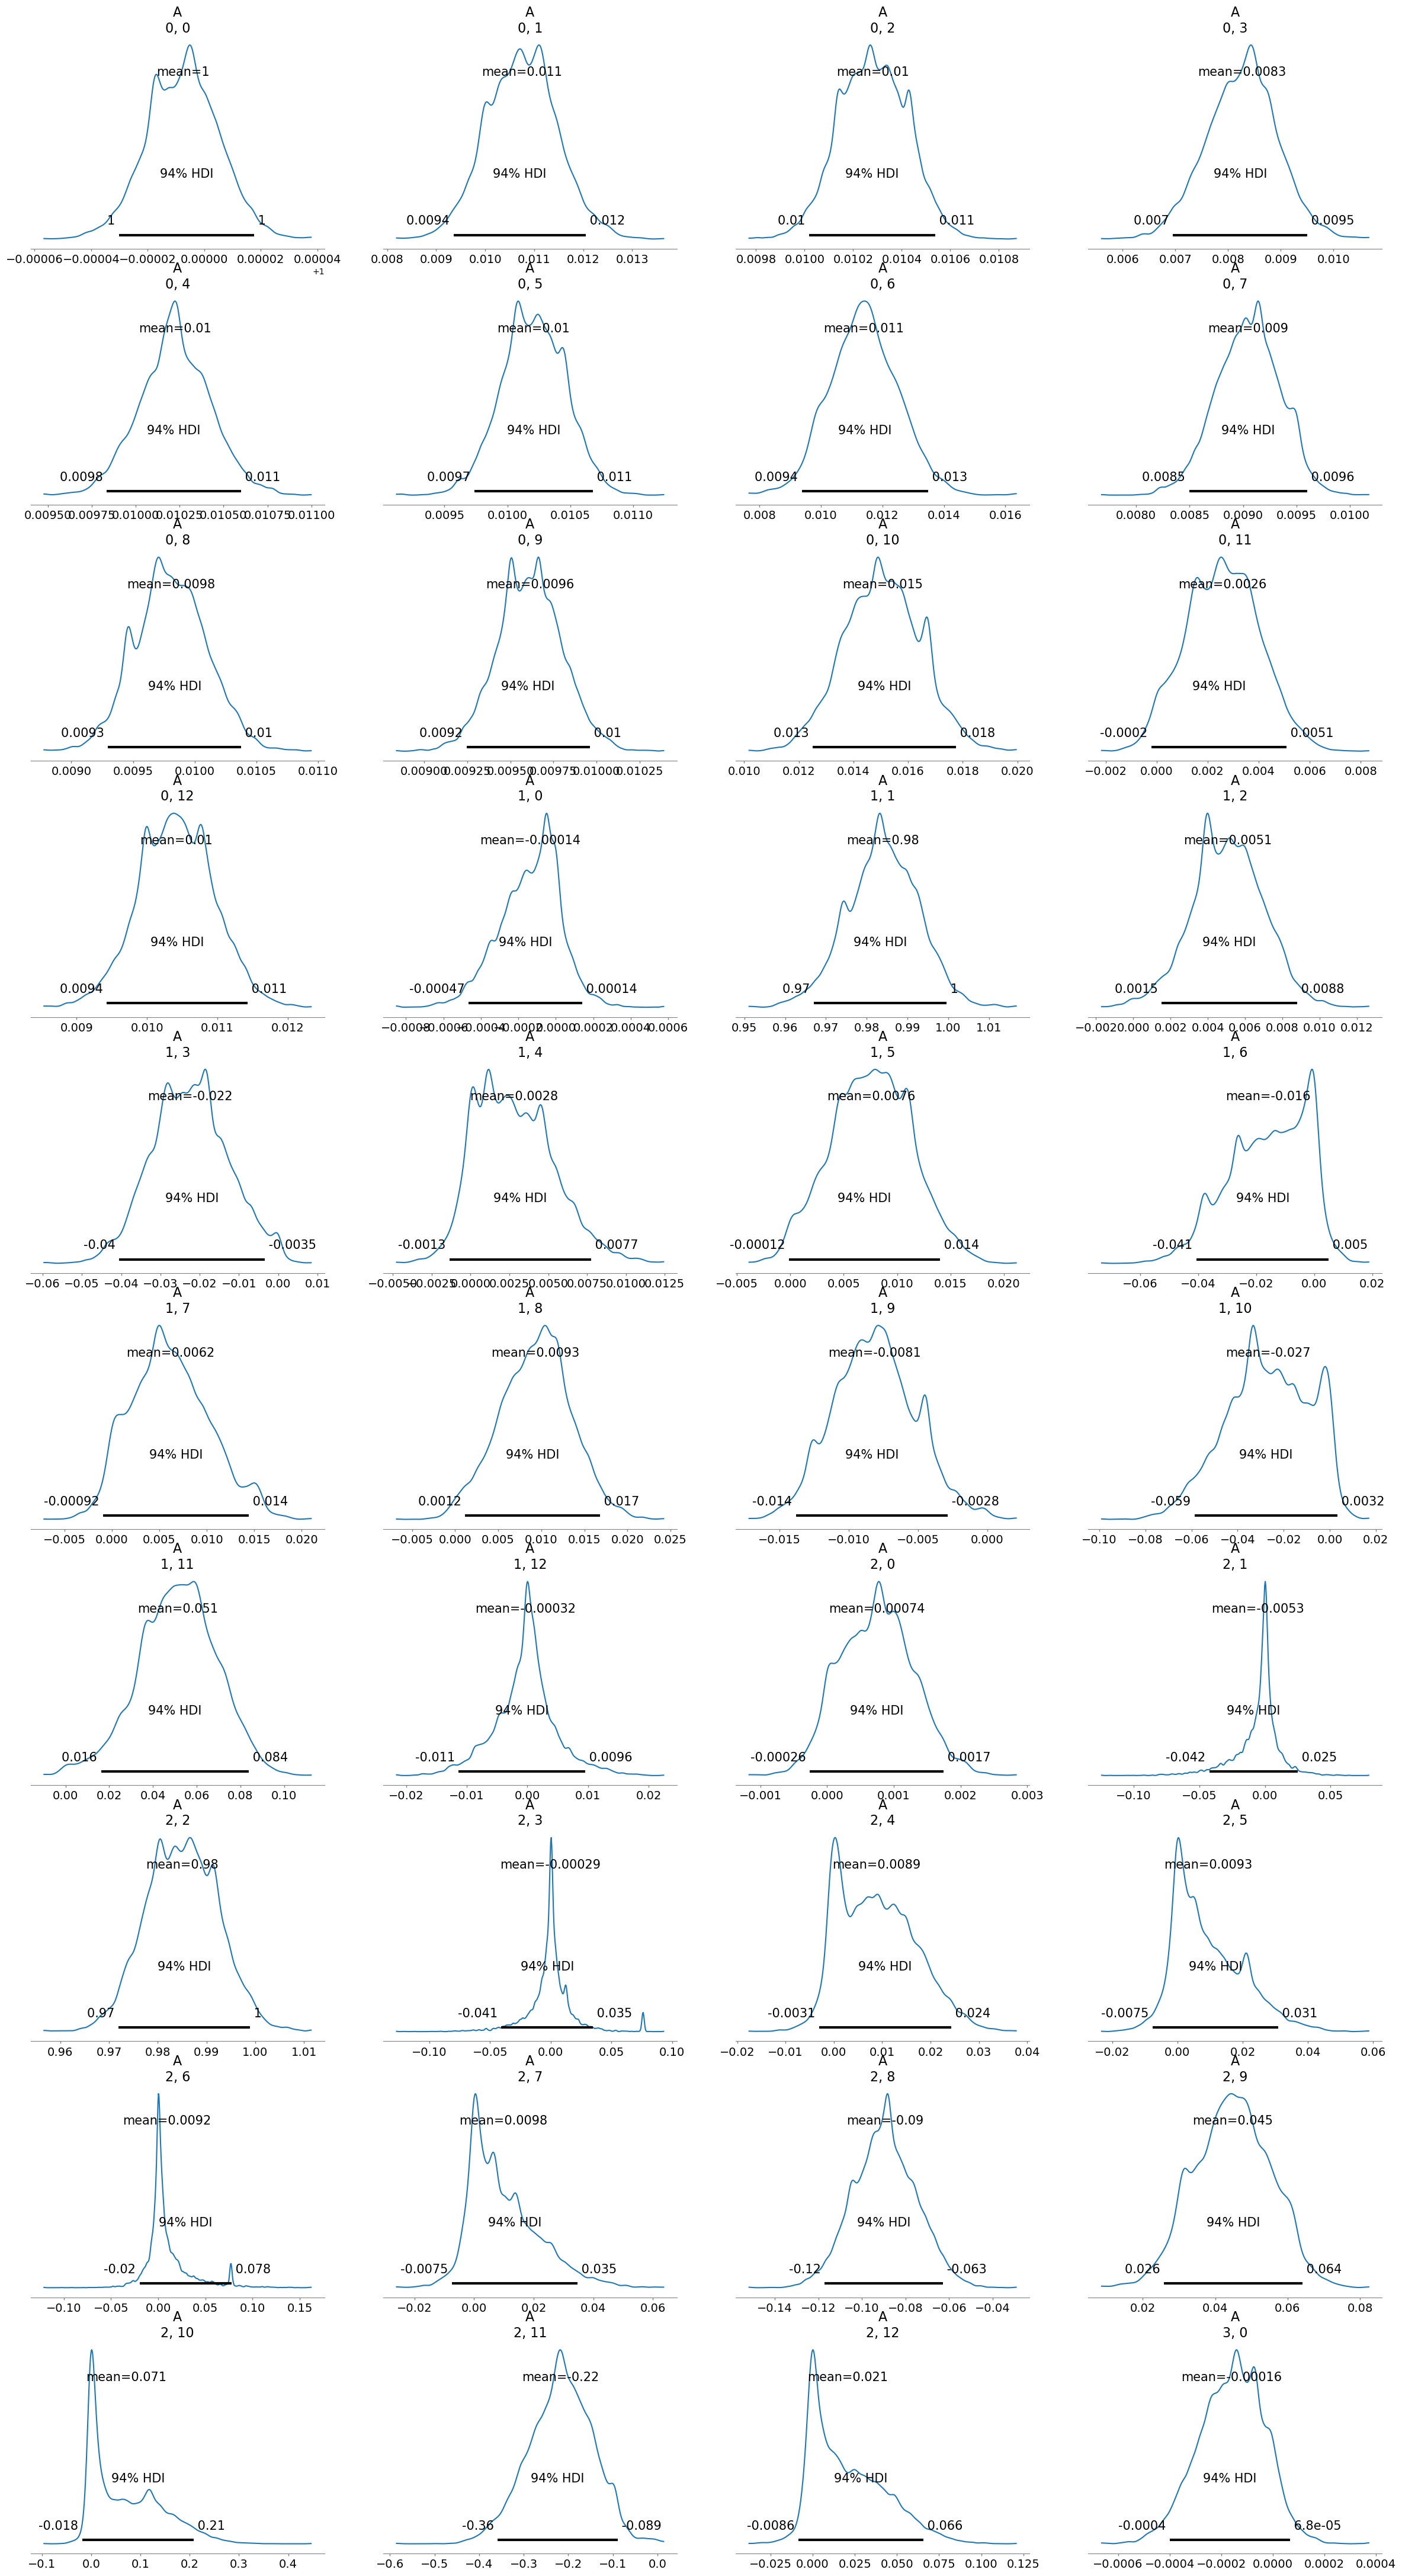

In [4]:
infer = infer_VAR(imputed_data)
infer.run_inference_large()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise_stddev, x0, c2, tau, lam, A, noise_chol]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 5889 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
A[0, 0]    1.000  0.000   1.000    1.000      0.000    0.000       5.0   
A[0, 1]   -0.000  0.000  -0.000    0.000      0.000    0.000       5.0   
A[0, 2]   -0.000  0.000  -0.000    0.000      0.000    0.000       5.0   
A[0, 3]    0.000  0.000  -0.000    0.000      0.000    0.000       5.0   
A[0, 4]    0.000  0.000  -0.000    0.000      0.000    0.000       5.0   
...          ...    ...     ...      ...        ...      ...       ...   
A[12, 8]   0.056  0.143  -0.118    0.275      0.072    0.055       4.0   
A[12, 9]   0.240  0.288  -0.063    0.650      0.144    0.110       4.0   
A[12, 10] -0.029  0.135  -0.229    0.138      0.068    0.052       4.0   
A[12, 11]  0.296  0.305  -0.069    0.759      0.152    0.117       4.0   
A[12, 12]  0.683  0.260   0.382    0.997      0.130    0.100       4.0   

           ess_tail  r_hat  
A[0, 0]        26.0   2.83  
A[0, 1]        26.0   2.84  
A[0, 2]        26.0   2.

c:\ProgramData\anaconda3\envs\MIMIC\Lib\site-packages\arviz\plots\plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (169) in plot_posterior, generating only 40 plots
  warnings.warn(


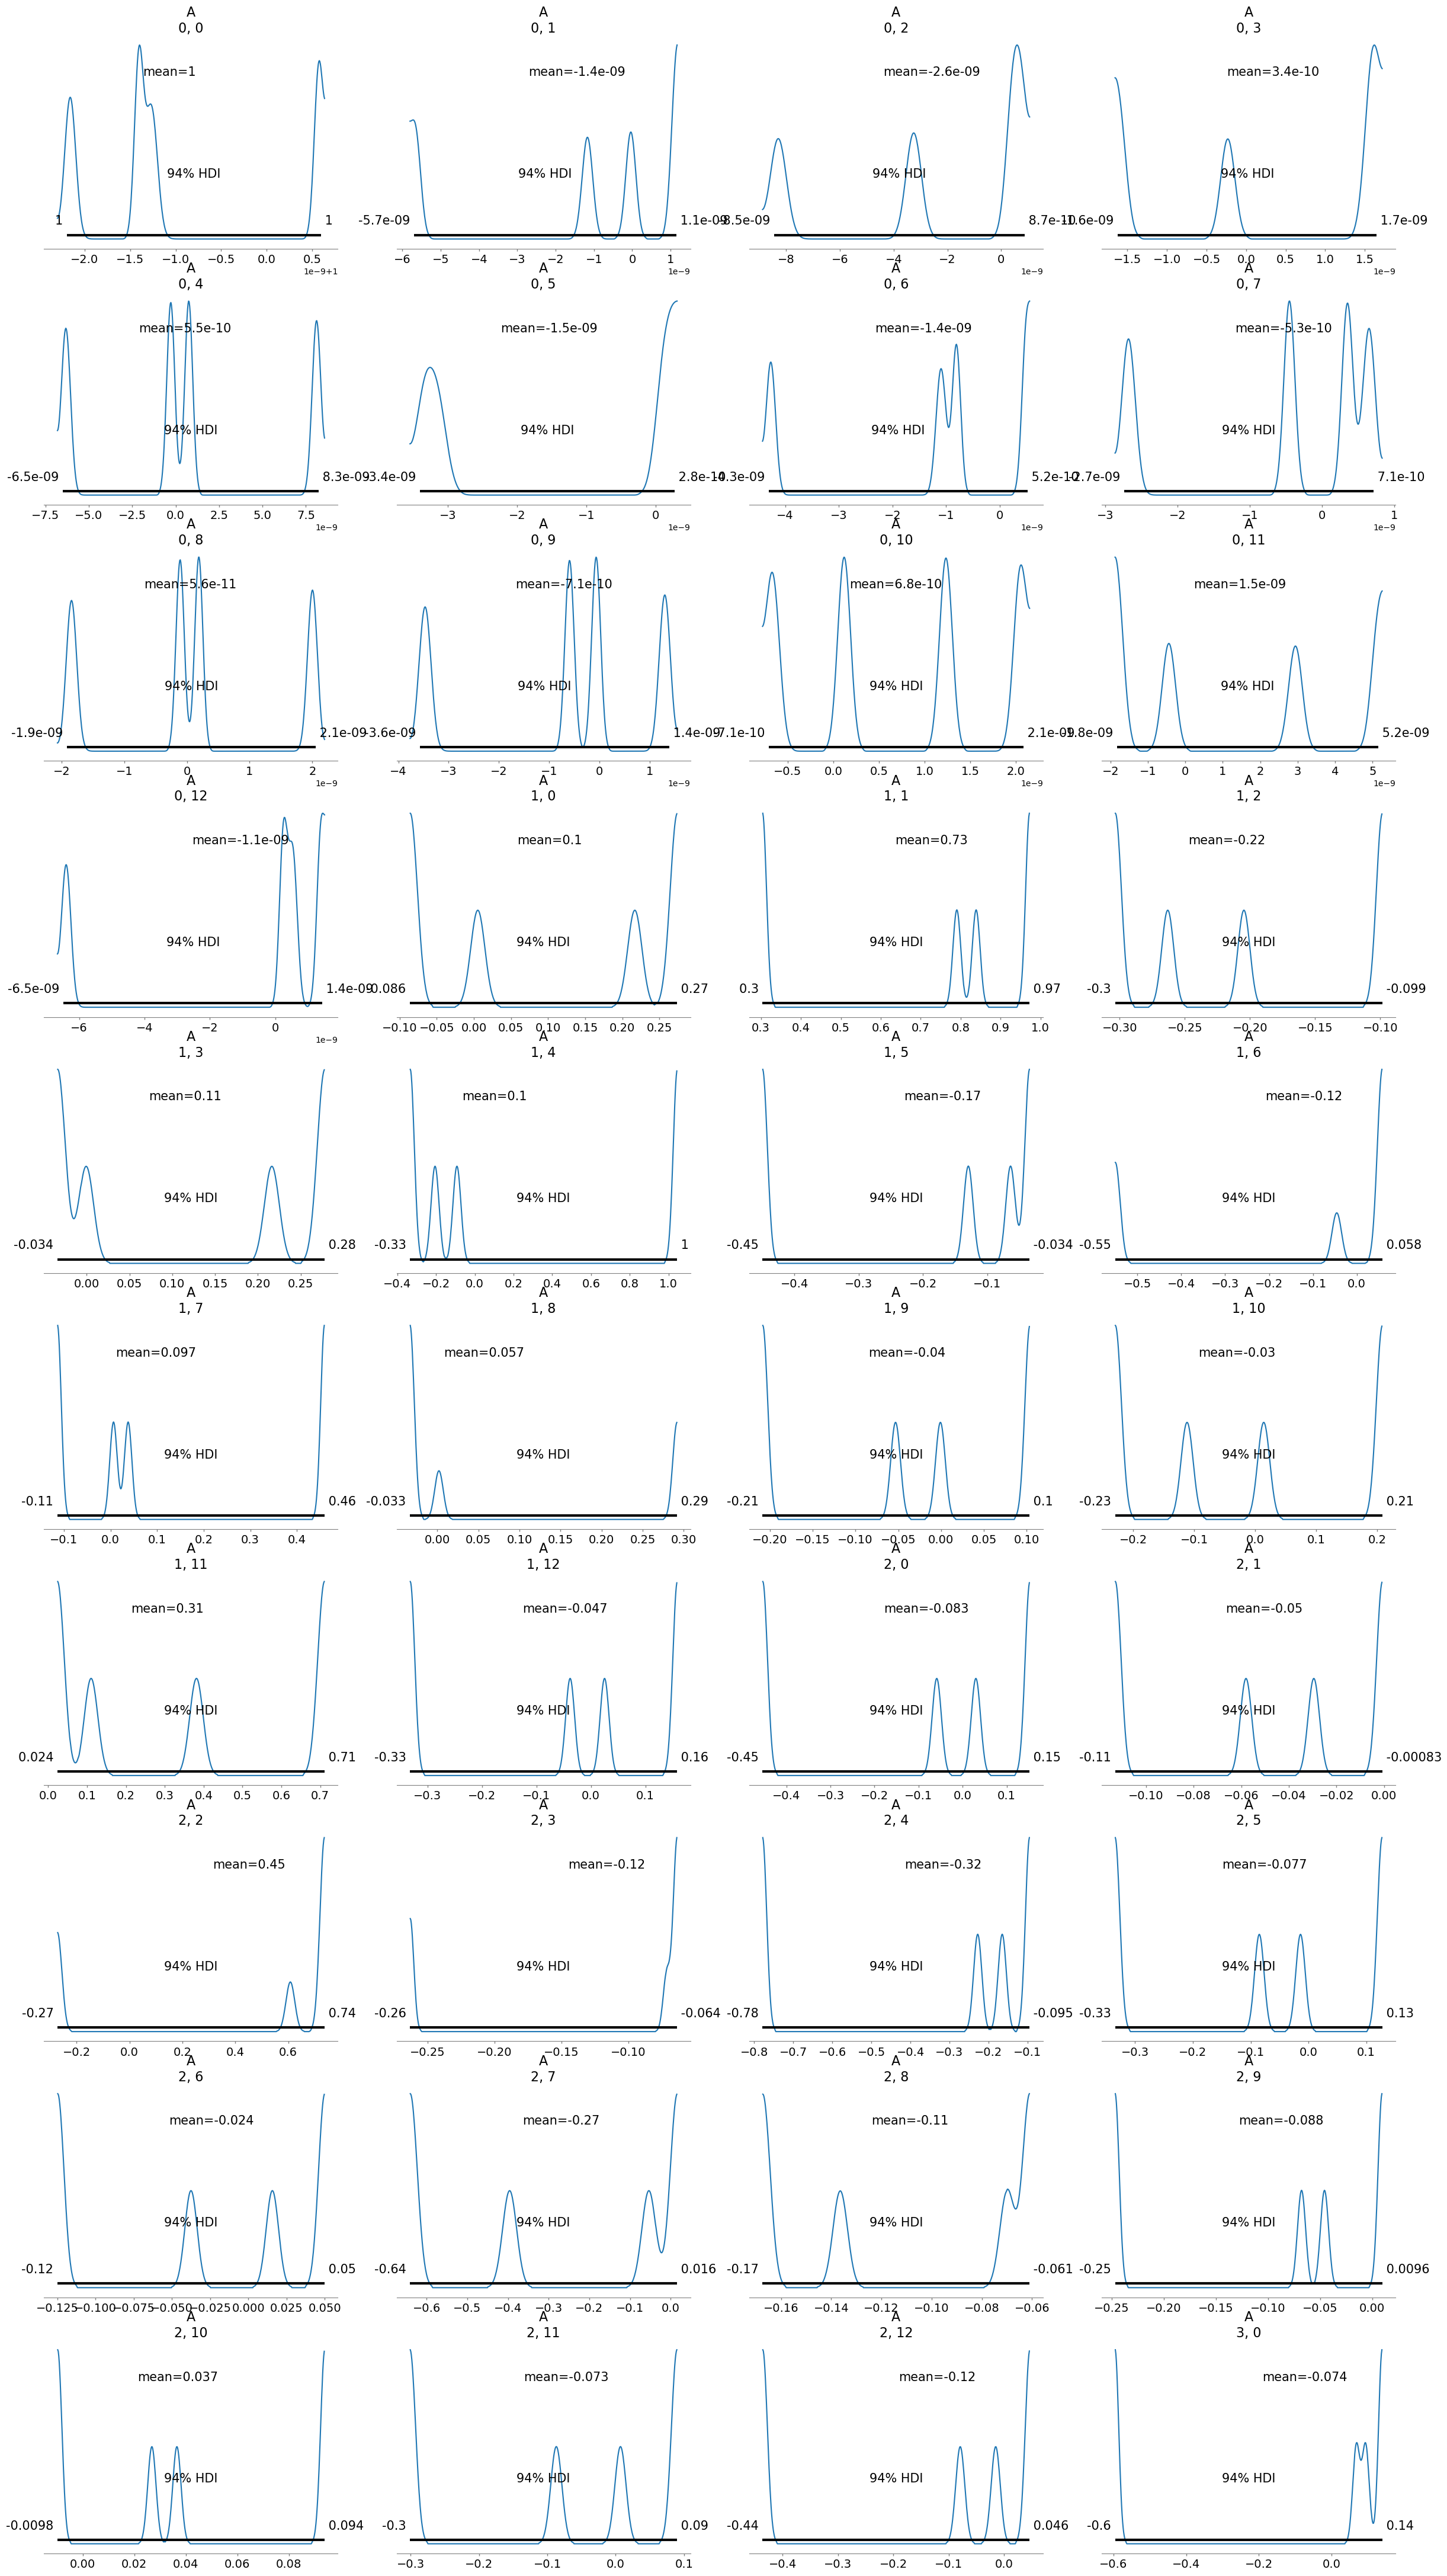

In [3]:
# Standardize data
normalized_data = (imputed_data - np.mean(imputed_data,
                   axis=0)) / np.std(imputed_data, axis=0)

# Initialize and run the model with standardized data
infer3 = infer_VAR(normalized_data)
infer3.run_inference_large()